In [16]:
import requests
import pandas as pd
from io import StringIO
import datetime
import time
import numpy as np

## 讀取台股股價資料

In [3]:
def get_year_month_str_from(year,month):
  year_month_arr = []
  today=datetime.datetime.today()
  while True:
    year_month_arr.append('%d%02d01' % (year,month))
    if year == today.year and month == today.month:
      break
    if month == 12:
      year += 1
      month = 1
    else:
      month += 1
  return year_month_arr

In [4]:
year_month_str = get_year_month_str_from(2017,1)

In [5]:
def transform_date(date):   #民國轉西元
        y, m, d = date.split('/')
        return str(int(y)+1911) + '/' + m  + '/' + d
    
def transform_value(data):   #將證交所獲得資料進行資料格式轉換
    data[0] = datetime.datetime.strptime(transform_date(data[0]), '%Y/%m/%d')
    data[1] = int(data[1].replace(',', ''))#把千進位的逗點去除
    data[2] = int(data[2].replace(',', ''))
    data[3] = float(data[3].replace(',', ''))
    data[4] = float(data[4].replace(',', ''))
    data[5] = float(data[5].replace(',', ''))
    data[6] = float(data[6].replace(',', ''))
    data[7] = float(0.0 if data[7].replace(',', '') == 'X0.00' else data[7].replace(',', ''))  # +/-/X表示漲/跌/不比價
    data[8] = int(data[8].replace(',', ''))
    return data
def transform(data):   #讀取每一個元素進行資料格式轉換，再產生新的串列
    return [transform_value(d) for d in data]

In [6]:
STOCK_NO='2330'

In [7]:
df = pd.DataFrame()
for datetimeStr in year_month_str:
  url = "http://www.twse.com.tw/exchangeReport/STOCK_DAY"
  params = {}
  params['stockNo'] = STOCK_NO
  params['date'] = datetimeStr
  r = requests.get(url, params=params)
  df = df.append(pd.DataFrame(transform(r.json()['data']),columns=r.json()['fields']),ignore_index = True)
  time.sleep(3)

In [29]:
df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,2017-01-03,23550783,4300648272,181.5,183.5,181.0,183.0,1.5,8743
1,2017-01-04,24482374,4478699942,183.0,184.0,181.5,183.0,0.0,8476
2,2017-01-05,21373561,3913389163,182.0,183.5,181.5,183.5,0.5,8297
3,2017-01-06,23120808,4250912732,184.0,184.5,183.5,184.0,0.5,9659
4,2017-01-09,18583788,3419409204,184.0,185.0,183.0,184.0,0.0,5759


## 選擇開盤價作為輸入

In [30]:
dataset = df.loc[:,['開盤價']].values

In [31]:
train_size = round(len(dataset)*0.8)
print(train_size)
train = dataset[:train_size]
test = dataset[train_size:]

528


In [32]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)
testing_set_scaled = sc.transform(test)

In [33]:
TIME_STEP = 60

In [34]:
X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點
for i in range(TIME_STEP, train_size):  # 1258 是訓練集總數
    X_train.append(training_set_scaled[i-TIME_STEP:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

In [35]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## 建立lstm模型

In [37]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
model = Sequential()

In [38]:
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mse')

## 訓練模型

In [40]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

W0911 16:24:00.607966 14948 deprecation.py:323] From C:\Users\Bigtongue\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0911 16:24:02.472002 14948 deprecation_wrapper.py:119] From C:\Users\Bigtongue\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/100
468/468 [==============================] - 6s 13ms/step - loss: 0.1040
Epoch 2/100
468/468 [==============================] - 2s 5ms/step - loss: 0.0256
Epoch 3/100
468/468 [==============================] - 2s 5ms/step - loss: 0.0196
Epoch 4/100
468/468 [==============================] - 2s 5ms/step - loss: 0.0166
Epoch 5/100
468/468 [==============================] - 2s 5ms/step - loss: 0.0158
Epoch 6/100
468/468 [==============================] - 2s 5ms/step - loss: 0.0144
Epoch 7/100
468/468 [==============================] - 2s 5ms/step - loss: 0.0145
Epoch 8/100
468/468 [==============================] - 2s 5ms/step - loss: 0.0147
Epoch 9/100
468/468 [==============================] - 2s 5ms/step - loss: 0.0144
Epoch 10/100
468/468 [==============================] - 2s 4ms/step - loss: 0.0123
Epoch 11/100
468/468 [==============================] - 2s 4ms/step - loss: 0.0125
Epoch 12/100
468/468 [==============================] - 2s 5ms/step - loss: 0.0132
Epoch 13/100

## 視覺化訓練損失

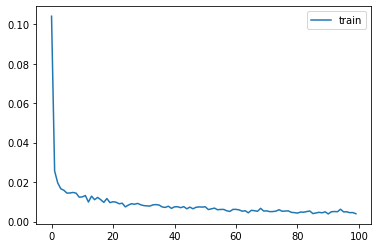

In [42]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
# plot history
plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 處理測試資料

In [85]:
X_concat = np.concatenate([train[-TIME_STEP:],test]) 
X_concat = sc.transform(X_concat)
# 先前的Timestep天資料與test資料
X_test = [X_concat[i-TIME_STEP:i, 0] for i in range(TIME_STEP, len(X_concat))]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [97]:
predicted_y_test = model.predict(X_test)
predicted_y_test = sc.inverse_transform(predicted_y_test)  # to get the original scale

## 視覺化預測結果

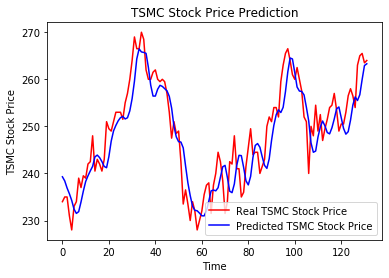

In [100]:
# Visualising the results
plt.plot(test, color = 'red', label = 'Real TSMC Stock Price')  # 紅線表示真實股價
plt.plot(predicted_y_test, color = 'blue', label = 'Predicted TSMC Stock Price')  # 藍線表示預測股價
plt.title('TSMC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSMC Stock Price')
plt.legend()
plt.show()